In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [267]:
sns.set_theme(style="ticks")
sns.set_style("whitegrid", {'axes.grid' : True})

In [220]:
def load_files_as_big_list(get="all"):
    output = []
    path_to_json = './Results/'
    json_files = [file for file in os.listdir(path_to_json) if file.endswith('.json')]
    c = 0
    for file_name in json_files:
        if get=="ca" and (f"-{get}-") not in file_name:
            c += 1
            continue
        elif get=="ac" and (f"-{get}-") not in file_name:
            c += 1
            continue
        elif get=="all":
            c += 1
            pass
        with open(path_to_json + file_name) as f:
            data = json.load(f)
            if (len(data) != 20):
                print(f"{len(data)} - {file_name}")
            
            # note: I'm including an extra entry for name
            data += [{"file name":file_name.replace(".json", "")}]
            output += data
    print (f"Number of files: {c}\n")
    return output

all_files = load_files_as_big_list()
ca_files = load_files_as_big_list(get="ca")
ac_files = load_files_as_big_list(get="ac")

19 - s-ca-eleanor.json
21 - s-ac-kevin.json
21 - s-ca-erin.json
22 - j-ac-sarah.json
Number of files: 32

19 - s-ca-eleanor.json
21 - s-ca-erin.json
Number of files: 18

21 - s-ac-kevin.json
22 - j-ac-sarah.json
Number of files: 14



In [213]:
columns=[header for header in all_files[0]]
print (columns)
myColumns = [
    'display mode', 'stage', 'test', 'target color', 
    'submitted color', 'selected colors', 'grid clicks', 'block clicks', 
    'strip clicks', 'compare clicks', 'time', 'file name',
] # not doing selected_colors just yet

['display mode', 'stage', 'test', 'target color', 'submitted color', 'selected colors', 'grid clicks', 'block clicks', 'strip clicks', 'compare clicks', 'time']


In [227]:
# data = {col:[] for col in myColumns}

def split_rgb_string(rgb):
    s = rgb.replace("(","").replace(")","")
    ls = s.split(",")
    return int(ls[0]), int(ls[1]), int(ls[2])

def parse_colors(myData):
    d = myData.copy()
    target_r = []
    target_g = []
    target_b = []
    submit_r = []
    submit_g = []
    submit_b = []
    for ele in myData['target color']:
        r,g,b = split_rgb_string(ele)
        target_r += [r]
        target_g += [g]
        target_b += [b]
    for ele in myData['submitted color']:
        r,g,b = split_rgb_string(ele)
        submit_r += [r]
        submit_g += [g]
        submit_b += [b] 
    
    del d['target color']
    del d['submitted color']
    d["target_r"] = target_r
    d["target_g"] = target_g
    d["target_b"] = target_b
    d["submit_r"] = submit_r
    d["submit_g"] = submit_g
    d["submit_b"] = submit_b
    
    d["r_diff"] = [abs(target_r[i] - submit_r[i]) for i in range(len(target_r))]
    d["g_diff"] = [abs(target_g[i] - submit_g[i]) for i in range(len(target_g))]
    d["b_diff"] = [abs(target_b[i] - submit_b[i]) for i in range(len(target_b))]
    d['total_diff'] = [(d["r_diff"][i] + d["g_diff"][i] + d["b_diff"][i]) for i in range(len(target_r))]
    return d  

def get_tabular_data(files):
    data = {col:[] for col in myColumns}
    count = 0
    for file in files:
        if "file name" in file:
            data['file name'] += [file['file name'] for i in range(count)]
            count = 0
        else:
            count += 1
            for ele in file:
                data[ele] += [file[ele]]
    return parse_colors(data)

all_data = get_tabular_data(all_files)
all_df = pd.DataFrame(all_data)
print (f"{len(all_files)} vs {len(all_df)}\n")

ca_data = get_tabular_data(ca_files)
ca_df = pd.DataFrame(ca_data)
print (f"{len(ca_files)} vs {len(ca_df)}\n")

ac_data = get_tabular_data(ac_files)
ac_df = pd.DataFrame(ac_data)
print (f"{len(ac_files)} vs {len(ac_df)}\n")

# NOTE: The difference is values is related to the filename

675 vs 643

294 vs 280

381 vs 363



In [228]:
all_df.head()

display mode  stage  test  \
0       custom      0     0   
1       custom      0     1   
2       custom      0     2   
3       custom      0     3   
4       custom      0     4   

                                     selected colors  grid clicks  \
0  [(125,127,63), (116,127,63), (174,196,67), (17...           27   
1  [(127,102,63), (152,109,42), (152,109,42), (17...           69   
2  [(127,63,90), (190,67,119), (156,34,85), (181,...           32   
3  [(76,63,127), (108,63,127), (60,13,81), (60,13...           10   
4  [(127,63,115), (127,63,73), (127,63,89), (209,...           11   

   block clicks  strip clicks  compare clicks     time    file name  target_r  \
0             4             5              19   76.433  j-ca-claire       200   
1             2             4              32  119.619  j-ca-claire       167   
2             5             4              29  103.108  j-ca-claire       174   
3            11             2               9   47.421  j-ca-claire        71   
4            13             7              16   92.856  j-ca-claire       196   

   target_g  target_b  submit_r  submit_g  submit_b  r_diff  g_diff  b_diff  \
0       215        50       195       217        42       5       2       8   
1       129        49       169       125        57       2       4       8   
2         3        97       174         9        92       0       6       5   
3        39        78        67        39        77       4       0       1   
4        73       131       194        73       124       2       0       7   

   total_diff  
0          15  
1          14  
2          11  
3           5  
4           9

In [229]:
subset_cols = [
    "grid clicks", "block clicks", "strip clicks", "compare clicks", 
    "time", "r_diff", "g_diff", "b_diff"
]
# all_df.groupby(["display mode"]).mean()
all_df.groupby(["display mode"]).mean()[subset_cols]

grid clicks  block clicks  strip clicks  compare clicks  \
display mode                                                            
adobe            1.059375     17.400000      4.475000       13.693750   
custom          14.628483      9.071207      4.244582       17.795666   

                   time     r_diff     g_diff     b_diff  
display mode                                              
adobe         65.673709  14.465625  11.375000  13.628125  
custom        82.232567  13.213622  10.356037  13.266254

Comments
- Users spent `more time with custom` but where `more accurate on average` across all 3 values of rgb
- Users spent `about the same time clicking the rainbow slider`, but had `disproportionate number of block clicks`. With the custom picker, there was a significant lesser amount of block-clicks. The differences in grid-clicks is related to the nature of the tests.

In [230]:
ac_df.head()

display mode  stage  test  \
0        adobe      0     0   
1        adobe      0     1   
2        adobe      0     2   
3        adobe      0     3   
4        adobe      0     4   

                                     selected colors  grid clicks  \
0  [(64,127,63), (29,92,28), (27,79,26), (27,81,2...            0   
1  [(127,122,63), (196,187,91), (196,187,91), (19...            0   
2  [(63,127,65), (54,156,57), (71,156,54), (88,19...            0   
3  [(92,127,63), (210,37,51), (210,19,35), (210,1...            0   
4  [(63,127,74), (92,127,63), (144,238,65), (218,...            0   

   block clicks  strip clicks  compare clicks    time   file name  target_r  \
0             5             1               4  18.348  s-ac-kevin        37   
1             9             5               7  41.156  s-ac-kevin       193   
2            11             8               3  35.496  s-ac-kevin       107   
3            13             9              15  67.050  s-ac-kevin       193   
4            26             5              21  84.534  s-ac-kevin       157   

   target_g  target_b  submit_r  submit_g  submit_b  r_diff  g_diff  b_diff  \
0        80        32        30        80        29       7       0       3   
1       156        19       191       157        34       2       1      15   
2       185        13       107       187        41       0       2      28   
3        31        56       193        28        59       0       3       3   
4       173        28       153       174        32       4       1       4   

   total_diff  
0          10  
1          18  
2          30  
3           6  
4           9

In [231]:
ca_df.head()

display mode  stage  test  \
0       custom      0     0   
1       custom      0     1   
2       custom      0     2   
3       custom      0     3   
4       custom      0     4   

                                     selected colors  grid clicks  \
0  [(125,127,63), (116,127,63), (174,196,67), (17...           27   
1  [(127,102,63), (152,109,42), (152,109,42), (17...           69   
2  [(127,63,90), (190,67,119), (156,34,85), (181,...           32   
3  [(76,63,127), (108,63,127), (60,13,81), (60,13...           10   
4  [(127,63,115), (127,63,73), (127,63,89), (209,...           11   

   block clicks  strip clicks  compare clicks     time    file name  target_r  \
0             4             5              19   76.433  j-ca-claire       200   
1             2             4              32  119.619  j-ca-claire       167   
2             5             4              29  103.108  j-ca-claire       174   
3            11             2               9   47.421  j-ca-claire        71   
4            13             7              16   92.856  j-ca-claire       196   

   target_g  target_b  submit_r  submit_g  submit_b  r_diff  g_diff  b_diff  \
0       215        50       195       217        42       5       2       8   
1       129        49       169       125        57       2       4       8   
2         3        97       174         9        92       0       6       5   
3        39        78        67        39        77       4       0       1   
4        73       131       194        73       124       2       0       7   

   total_diff  
0          15  
1          14  
2          11  
3           5  
4           9

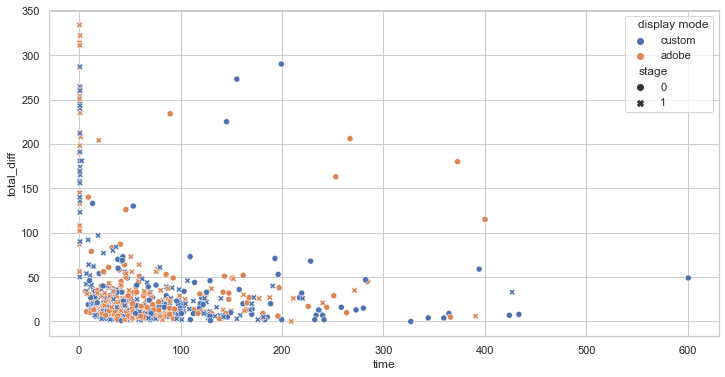

In [288]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.scatterplot(data=all_df, x='time', y='total_diff', hue='display mode', style="stage",ax=ax)
plt.show()

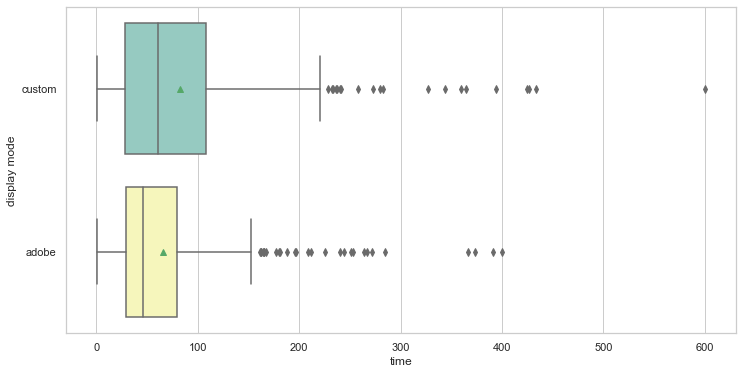

In [297]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.boxplot(y="display mode", x="time", data=all_df, palette="Set3", orient="h", showmeans=True, ax=ax)
plt.show();

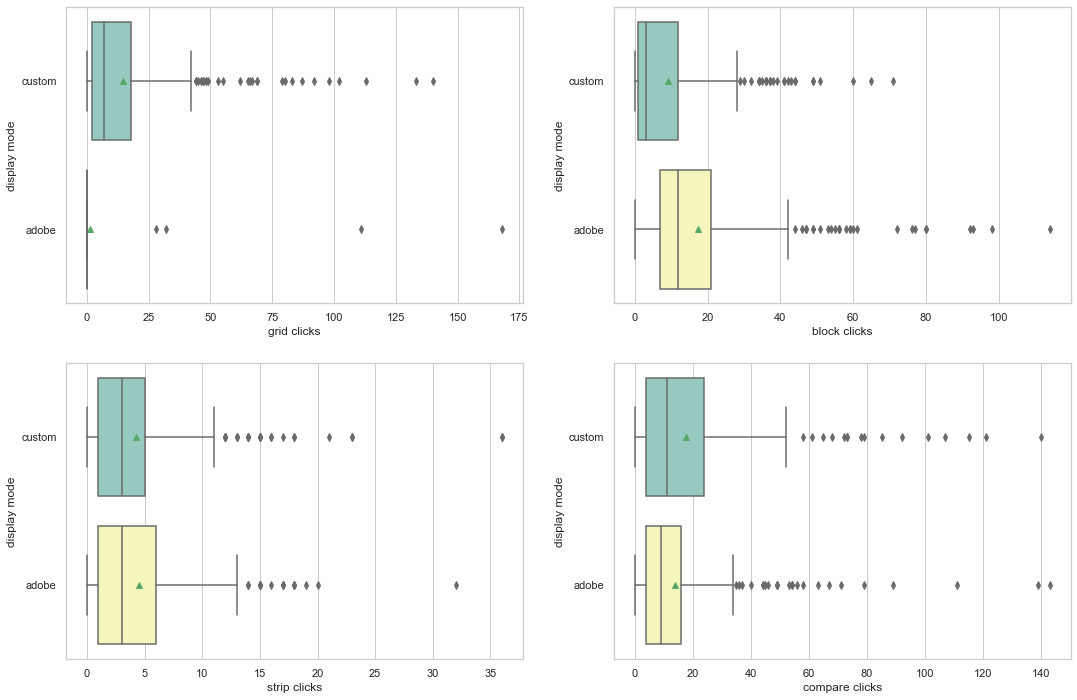

In [280]:
fig, axs = plt.subplots(2,2, figsize=(18,12))
sns.boxplot(y="display mode", x="grid clicks", data=all_df, palette="Set3", orient="h", ax=axs[0][0], showmeans=True)
sns.boxplot(y="display mode", x="block clicks", data=all_df, palette="Set3", orient="h", ax=axs[0][1], showmeans=True)
sns.boxplot(y="display mode", x="strip clicks", data=all_df, palette="Set3", orient="h", ax=axs[1][0], showmeans=True)
sns.boxplot(y="display mode", x="compare clicks", data=all_df, palette="Set3", orient="h", ax=axs[1][1], showmeans=True)
plt.show()

In [253]:
describe_columns = [
    "grid clicks","block clicks","strip clicks",
    "compare clicks","time","total_diff",
]

In [254]:
all_df[all_df['display mode'] == "custom"].describe()[describe_columns]

grid clicks  block clicks  strip clicks  compare clicks        time  \
count   323.000000    323.000000    323.000000      323.000000  323.000000   
mean     14.628483      9.071207      4.244582       17.795666   82.232567   
std      21.243444     12.612151      4.863247       20.873809   82.473812   
min       0.000000      0.000000      0.000000        0.000000    0.606000   
25%       2.000000      1.000000      1.000000        4.000000   28.037500   
50%       7.000000      3.000000      3.000000       11.000000   60.708000   
75%      18.000000     12.000000      5.000000       24.000000  107.792000   
max     140.000000     71.000000     36.000000      140.000000  600.417000   

       total_diff  
count  323.000000  
mean    36.835913  
std     56.079422  
min      0.000000  
25%      8.000000  
50%     18.000000  
75%     35.000000  
max    311.000000

In [238]:
all_df[all_df['display mode'] == "adobe"].describe()[describe_columns]

grid clicks  block clicks  strip clicks  compare clicks        time  \
count   320.000000    320.000000    320.000000      320.000000  320.000000   
mean      1.059375     17.400000      4.475000       13.693750   65.673709   
std      11.473545     17.924152      4.474869       17.835717   64.808895   
min       0.000000      0.000000      0.000000        0.000000    0.448000   
25%       0.000000      7.000000      1.000000        4.000000   29.438500   
50%       0.000000     12.000000      3.000000        9.000000   46.480500   
75%       0.000000     21.000000      6.000000       16.000000   79.675750   
max     168.000000    114.000000     32.000000      143.000000  400.191000   

       total_diff  
count  320.000000  
mean    39.468750  
std     62.345676  
min      0.000000  
25%      9.000000  
50%     18.000000  
75%     34.000000  
max    334.000000

Explore the following visualizations
- https://seaborn.pydata.org/examples/grouped_boxplot.html
- https://seaborn.pydata.org/examples/horizontal_boxplot.html
- https://seaborn.pydata.org/examples/faceted_histogram.html
- https://seaborn.pydata.org/examples/anscombes_quartet.html
- https://seaborn.pydata.org/examples/scatterplot_matrix.html
- https://seaborn.pydata.org/examples/wide_form_violinplot.html

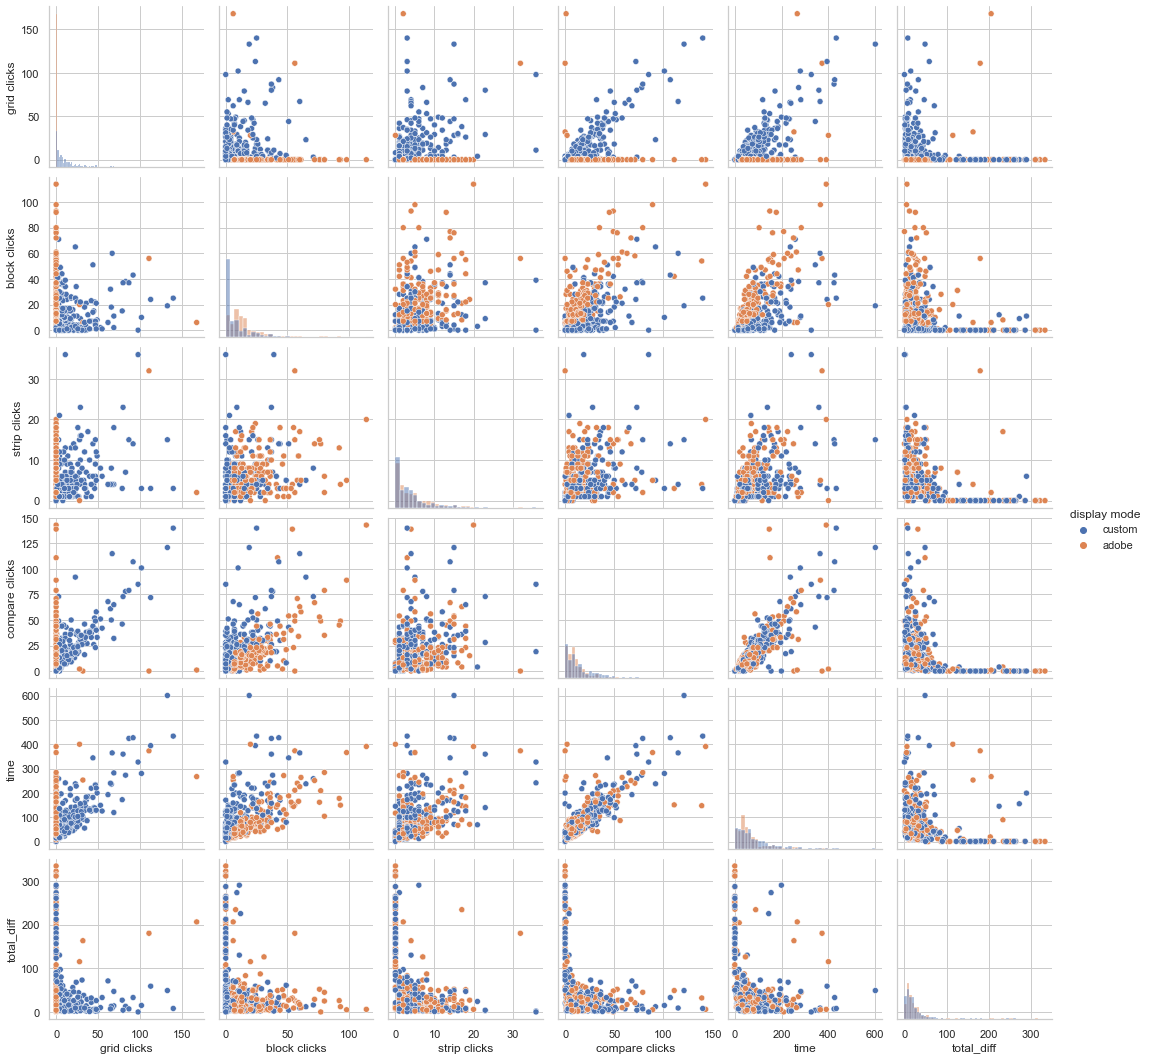

In [290]:
sns.pairplot(
    all_df[describe_columns + ["display mode"]], 
    hue='display mode',
    diag_kind="hist", # feel free to remove this parameter for more visually appealing distributions
)
plt.show()

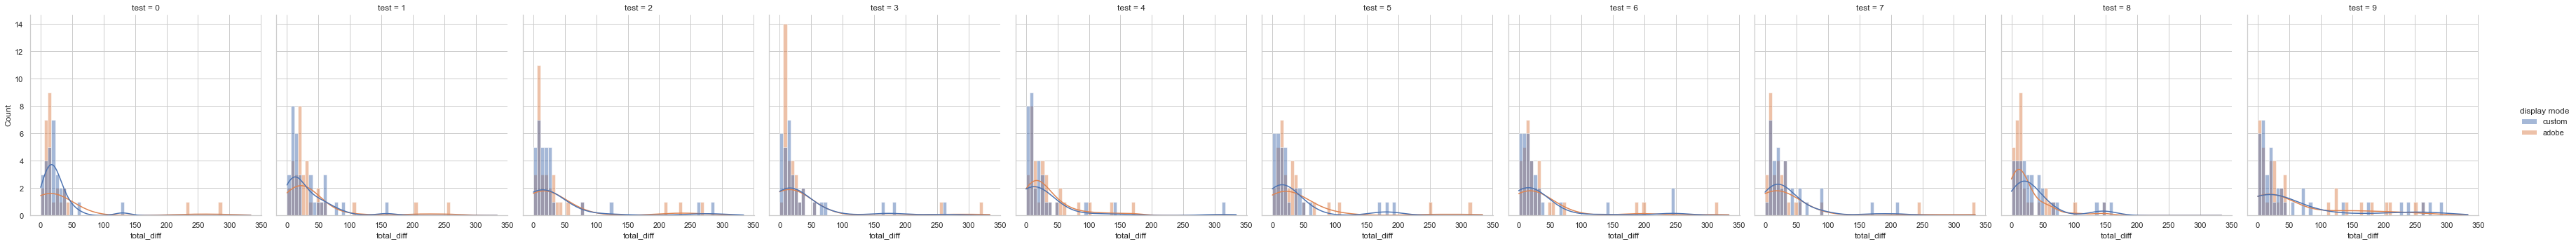

In [303]:
sns.displot(data=all_df, x="total_diff", hue="display mode", col="test",kde=True)
plt.show()

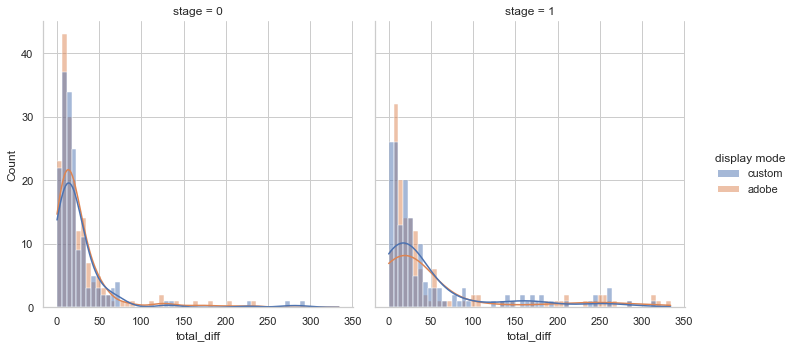

In [304]:
sns.displot(data=all_df, x="total_diff", hue="display mode", col="stage",kde=True)
plt.show()